In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from ch_est_net.nets import *
from ch_est_net import Trainer

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         zero.pt
data.h5            Notebooks/         requirements.txt
DMRS_signal/       one.pt             results/
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
d_re, d_im, id_re, id_im = DFT_matrixes(512,512,True)
IDFT = id_re + 1j* id_im 
DFT = d_re + 1j*d_im
IDFT.shape


a = torch.rand(48,1)+1j*torch.rand(48,1)

#DFT = DFT[:48,:512]
DFT = DFT[:48,:512]
IDFT = DFT.conj().T


In [4]:
u,s,v = torch.svd(DFT)

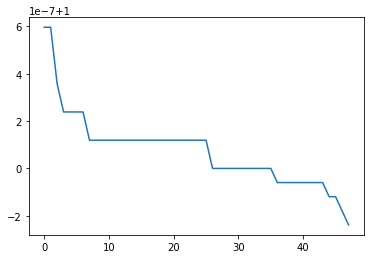

In [13]:
plt.plot(s)

In [4]:
A = torch.tensor(scipy.linalg.dft(512), dtype = torch.complex64)
B = A.conj().T

In [14]:
plt.imshow(abs(A@B))
plt.colorbar()

NameError: name 'A' is not defined

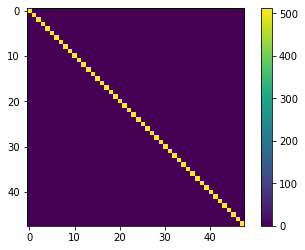

In [117]:
plt.imshow(abs(A[:48,:]@B[:,:48]))
plt.colorbar()

In [40]:
torch.linalg.matrix_norm(DFT[:48,:512], 2)

tensor(1.0000)

In [240]:
a = torch.rand(512)*torch.rand(512)+1j*torch.rand(512)*torch.rand(512)
ans1 = torch.linalg.vector_norm(a).numpy()*1
ans1

10.983806610107422

In [241]:
ans2 = torch.linalg.vector_norm(A[:48,:]@ a).numpy() * (1/(512)**0.5)
ans2

8.583333825663042

In [262]:
ans1/ans2

1.2796667161269297

In [159]:
torch.linalg.matrix_norm(A[:48,:],1)

tensor(48.)

In [161]:
torch.linalg.matrix_norm(A[:,:48],1)

tensor(512.)

In [109]:
18.922943/16.822624

1.1248508556096837

In [5]:
torch.linalg.matrix_norm(DFT,2)

tensor(1.0000)

In [15]:
class Tied_LAMP_Head_Layer(torch.nn.Module):
    def __init__(self, beta = 1.0, alpha = 0.02, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_Head_Layer, self).__init__()
        
        self.beta =  nn.Parameter(torch.tensor(beta, dtype = torch.float64), requires_grad = False)
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype = torch.float64), requires_grad = True)
        self.activation = getattr(ch_est_net.activation, activation_class)
        self._is_pass = False


    def forward(self, x_hat, v, y, A, B):
        if self._is_pass == False:
                
            M = torch.tensor(A.shape[0])
            assert M == 48, ''

            r = x_hat + B@v

            sigma = 1.0/torch.sqrt(M) * torch.linalg.vector_norm(v, ord=2)
            lambd = self.alpha * sigma
            x_hat = self.beta * self.activation.function(r,lambd)
            b = self.beta/M * torch.linalg.vector_norm(x_hat, ord =0)
            v = y - A@x_hat + b*v

        return x_hat, v 

    def setTrainable(self, state: bool):
        if state == True:
            self.alpha.requires_grad = True
        else:
            self.alpha.requires_grad = False
            self.alpha.grad = None

#=============================================================================

class Tied_LAMP_Layer(torch.nn.Module):
    def __init__(self, beta = 1.0, alpha = 0.02, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_Layer, self).__init__()
        
        self.beta = nn.Parameter(torch.tensor(beta, dtype = torch.float64), requires_grad = True)
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype = torch.float64), requires_grad = True)
        self.activation = getattr(ch_est_net.activation, activation_class)

        self._is_pass = False


    def forward(self, x_hat, v, y, A, B):
        if self._is_pass == False:
                
            M = torch.tensor(A.shape[0])
            assert M == 48, ''

            r = x_hat + B@v

            sigma = 1.0/torch.sqrt(M) * torch.linalg.vector_norm(v, ord=2)
            lambd = self.alpha * sigma
            x_hat = self.beta * self.activation.function(r,lambd)
            b = self.beta/M * torch.linalg.vector_norm(x_hat, ord =0)
            v = y - A@x_hat + b*v

        return x_hat, v 

    def setTrainable(self, state: bool):
        if state == True:
            self.beta.requires_grad = True
            self.alpha.requires_grad = True
        else:
            self.beta.requires_grad = False
            self.beta.grad = None
            self.alpha.requires_grad = False
            self.alpha.grad = None


#=============================================================================

class Tied_LAMP_final(torch.nn.Module):
    def __init__(self, A, layers: int, delta = 1.0, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_final,self).__init__()

        self.net = torch.nn.ModuleList(
            [Tied_LAMP_Layer(beta=0.1, alpha=0.1, activation_class = activation_class) for i in range(layers-1)]
        )

        self.net.insert(0, Tied_LAMP_Head_Layer(beta=1.0, alpha = 0.1))

        self.A = A 
        self.B = nn.Parameter(torch.clone(A).conj().T.detach(), requires_grad = True)
        self.M , self.N = torch.tensor(A.shape[0]), torch.tensor(A.shape[1])
        self.delta = delta

        assert self.M <= self.N, 'M assumed to be <= N'

        self.layers = layers


    
    def forward(self, y):
        y = y.T

        maximum = torch.linalg.vector_norm(y,ord = float('inf'))
        y= y/maximum * self.delta

        x_hat = torch.zeros(self.N, y.shape[1], dtype = self.A.dtype)
        v = y
        
        assert list(x_hat.shape) == [512,64], 'Size is {0}'.format(list(x_hat.shape))
        assert list(v.shape) == [48,64], 'Size is {0}'.format(list(v.shape))
        
        for layer in self.net:
            x_hat, v = layer.forward(x_hat, v, y, self.A, self.B) 

        x = self.A@x_hat

        x = x*maximum / self.delta

        return x.T

    def set_params_prev_layer(self, i:int):
        state = self.net[i-1].state_dict()

        if i ==1:
            state['beta'] = torch.tensor(0.01, dtype = torch.float64)

        self.net[i].load_state_dict(state)



    def setState(self, trainable_code, pass_code):

        c = [bool(int(d)) for d in str(trainable_code)]
        p = [bool(int(d)) for d in str(pass_code)]

        for i, module in enumerate(self.net):
            module.setTrainable(c[i])
            module._is_pass = p[i]




# class Tied_LAMP(torch.nn.Module):
#     def __init__(self, A, layers: int, activation_class = 'complex_soft_threshold'):
#         super(Tied_LAMP, self).__init__()

#         self.activation = getattr(ch_est_net.activation, activation_class)
#         self.layers = layers
#         self.M, self.N = torch.tensor(A.shape[0]), torch.tensor(A.shape[1])
#         self.A = A

#         assert self.M <= self.N, 'M assumed to be <= N'

#         self.alphas = nn.Parameter(torch.ones(layers, dtype = torch.float64)/10.0, requires_grad = True)
#         self.betas = nn.Parameter(torch.ones(layers-1, dtype = torch.float64)/10.0, requires_grad = True)
#         self.B = nn.Parameter(A.conj().T, requires_grad = True)

#     def forward(self, y):
#         y = y.T
        
#         maximum = torch.linalg.vector_norm(y, ord= float('inf'))
#         y = y/maximum * 10 

#         x_hat = torch.zeros(self.N, y.shape[1], dtype = self.A.dtype)
#         v = torch.zeros(y.shape, dtype = self.A.dtype)
        
#         assert list(x_hat.shape) == [512,64], 'Size is {0}'.format(list(x_hat.shape))
#         assert list(v.shape) == [48,64], 'Size is {0}'.format(list(v.shape))
        
#         for t in range(self.layers):
#             if t == 0 :
#                 beta = 1.0 
#             else:
#                 beta = self.betas[t-1]

#             r = x_hat + self.B @ v
#             sigma = 1.0/torch.sqrt(self.M)*torch.linalg.vector_norm(v, ord = 2)
#             lambd = self.alphas[t] * sigma
#             x_hat = beta * self.activation.function(r,lambd)
#             b = beta/self.M * torch.linalg.vector_norm(x_hat, ord = 0)
#             v = y - self.A @ x_hat + b*v
        

#         x = self.A @ x_hat
#         x = x*maximum / 10

#         return x.T

In [16]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch

In [19]:
x_batch, u_batch, _, _ = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
                                              ind_range = range(1, 140, 3),
                                              seed = 3)

x_test, u_test, _, _ = get_batch(snr_range = [-10, -9, -5 , -2 , -1],
                                              ind_range = range(2, 141, 3),
                                              seed = 2)

x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [18]:
# x_batch, u_batch, _, _ = get_batch(snr_range = [-6 , -3 ,0],
#                                               ind_range = [10],
#                                               seed = 3)


# x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
# u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

In [25]:
x_batch.shape

torch.Size([3, 64, 48])

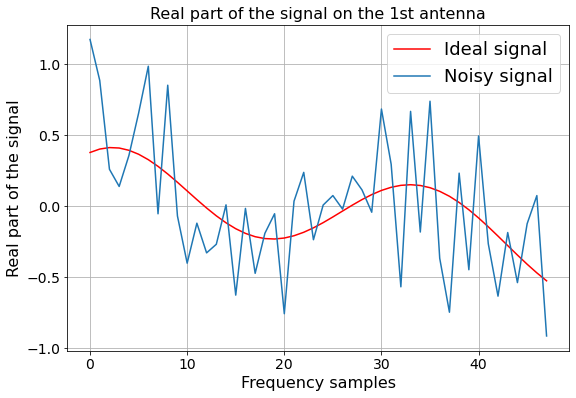

In [56]:
plt.figure(figsize=(9,6))
plt.title("Real part of the signal on the 1st antenna", fontsize = 16)
plt.plot(x_batch[2,1,:].real, label = 'Ideal signal', color ='red')
plt.plot(u_batch[2,1,:].real, label = 'Noisy signal')
plt.xlabel("Frequency samples", fontsize = 16)
plt.ylabel("Real part of the signal", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 18})
plt.grid()

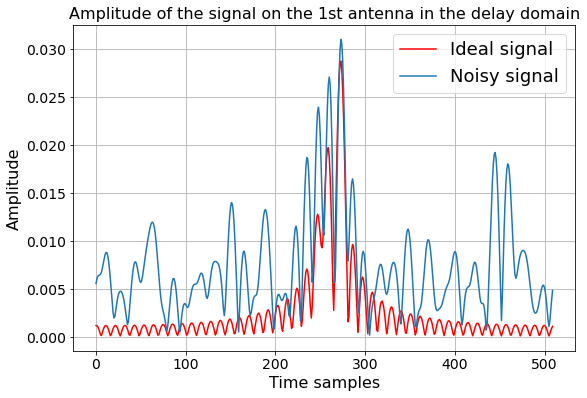

In [93]:
plt.figure(figsize=(9,6))
plt.title("Amplitude of the signal on the 1st antenna in the delay domain", fontsize = 16)
plt.plot((abs(torch.fft.fftshift(torch.fft.ifft(x_batch[2,1,:], 510)))), label = 'Ideal signal', color ='red')
plt.plot((abs(torch.fft.fftshift(torch.fft.ifft(u_batch[2,1,:], 510)))),label = 'Noisy signal')
#plt.plot(x_batch[2,1,:].real, label = 'Ideal signal', color ='red')
#plt.plot(u_batch[2,1,:].real, label = 'Noisy signal')
plt.xlabel("Time samples", fontsize = 16)
plt.ylabel("Amplitude", fontsize = 16)
#plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 18})
plt.grid()

In [20]:
import torch
from torch.nn.functional import mse_loss
import numpy as np


def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse


def train_net(data_noisy, data,  model, optimizer):
    device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Starting Training using device : ', device)

    model.to(device)
    criterion = MSE  
    n_epochs = 100
    
    train_mses = []
    test_mses = []

    for epoch in range(n_epochs):
        model.train()
        current_mse = torch.tensor(0.0 , dtype= torch.float64)
        optimizer.zero_grad() 

        # training 
        for cur_data_idx in range(data.shape[0]):
            x = data[cur_data_idx,:].type(torch.complex64).detach()
            y = data_noisy[cur_data_idx,:].type(torch.complex64).detach()

            x_hat = model(y)
            
            current_mse += criterion(x, x_hat)
        

        current_mse.backward(retain_graph = True)
        optimizer.step()
        
        train_mses.append(current_mse.item())

        print('Epoch: {0}. Train Loss : {1}.'.format(epoch, current_mse))
        del current_mse

    return model, train_mses

In [23]:
lamp = Tied_LAMP_final(DFT,1)
trainer = Trainer.Scenary_Trainer(lamp,MSE)

In [24]:
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 2000)



 Stage  0
Epoch: 0. Train Loss : 125.03160. Test Loss:  91.94926
Epoch: 5. Train Loss :  59.29059. Test Loss:  85.37680
Epoch: 10. Train Loss :  36.30275. Test Loss:  51.06987
Epoch: 15. Train Loss :  32.91973. Test Loss:  47.16466
Epoch: 20. Train Loss :  30.52480. Test Loss:  50.59003
Epoch: 25. Train Loss :  29.49731. Test Loss:  48.12291
Epoch: 30. Train Loss :  27.95511. Test Loss:  45.07607
Epoch: 35. Train Loss :  27.12087. Test Loss:  43.40157
Epoch: 40. Train Loss :  26.88473. Test Loss:  42.90817
Epoch: 45. Train Loss :  26.70193. Test Loss:  42.80875
Epoch: 50. Train Loss :  26.38162. Test Loss:  42.78109
Epoch: 55. Train Loss :  26.04353. Test Loss:  42.83368
Epoch: 60. Train Loss :  25.91305. Test Loss:  42.85729
Epoch: 65. Train Loss :  25.88528. Test Loss:  42.85539
Epoch: 70. Train Loss :  25.85718. Test Loss:  42.84866
Epoch: 75. Train Loss :  25.82895. Test Loss:  42.83955
Epoch: 80. Train Loss :  25.81086. Test Loss:  42.83490
Epoch: 85. Train Loss :  25.80798. Tes

In [68]:
torch.save(trainer.model.state_dict(), 'zero.pt')

In [88]:
x_batch.shape

torch.Size([235, 64, 48])

23


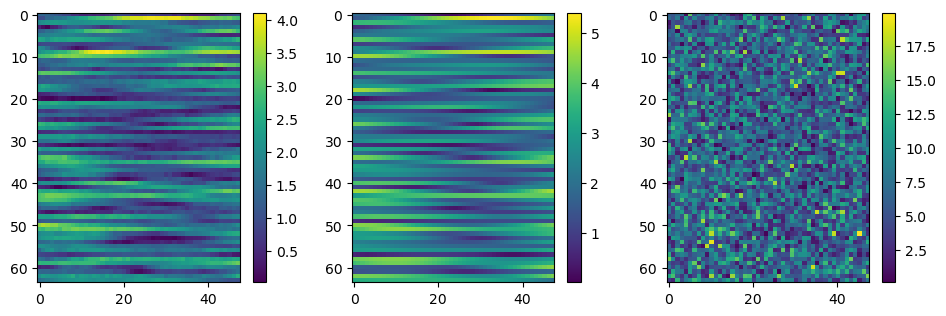

In [209]:
idx = np.random.randint(0,235)
x = x_batch[idx,:].type(torch.complex64).detach()
y = u_batch[idx,:].type(torch.complex64).detach()

x_hat = trainer.model(y)
plt.figure(figsize = (11.5,3.5))
plt.subplot(1,3,1)
plt.imshow(abs(x_hat).detach().numpy())
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(abs(x))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(abs(y))
plt.colorbar()

print(idx)


In [ ]:
lamp2 = Tied_LAMP_final(DFT,1)

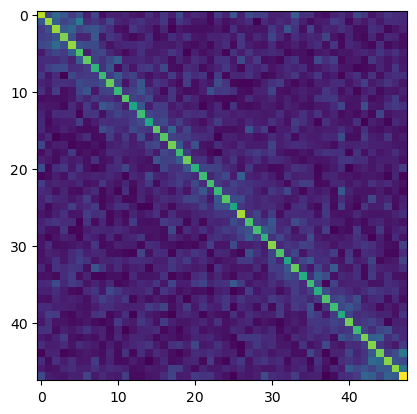

In [199]:
#plt.figure(figsize=(15,5))
plt.imshow(abs(trainer.model.A.data @ trainer.model.B.data))

Text(0.5, 1.0, 'First layer learning')

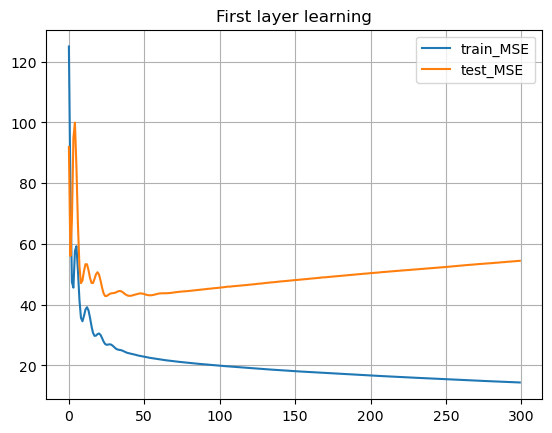

In [191]:
plt.plot(trainer.train_loss_history[:300], label = 'train_MSE')
plt.plot(trainer.test_loss_history[:300], label = 'test_MSE')
plt.grid()
plt.legend()
plt.title('First layer learning')

Text(0.5, 1.0, 'First layer learning')

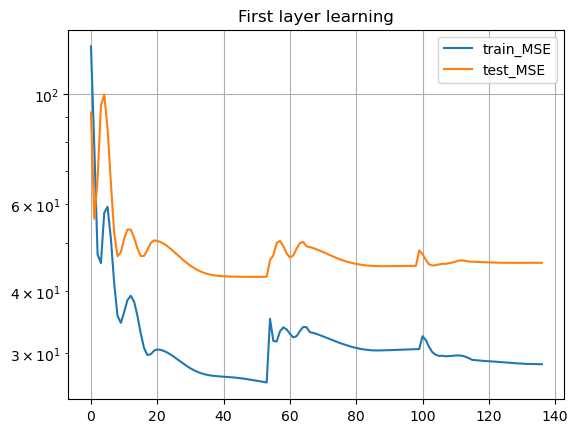

In [210]:
plt.plot(trainer.train_loss_history[:300], label = 'train_MSE')
plt.plot(trainer.test_loss_history[:300], label = 'test_MSE')
plt.grid()
plt.yscale('log')
plt.legend()
plt.title('First layer learning')

In [219]:
torch.save(trainer.model.state_dict(),'zero.pt')

In [293]:
state 

OrderedDict([('B',
              tensor([[ 0.0753+0.0304j,  0.0883+0.0059j,  0.0933+0.0008j,  ...,
                        0.0982+0.0176j,  0.0830-0.0141j,  0.1017-0.0080j],
                      [ 0.0813+0.0296j,  0.0868-0.0020j,  0.0862-0.0046j,  ...,
                        0.0897-0.0323j,  0.0664-0.0549j,  0.0841-0.0603j],
                      [ 0.0884+0.0239j,  0.0840-0.0128j,  0.0786-0.0081j,  ...,
                        0.0604-0.0683j,  0.0328-0.0810j,  0.0447-0.0952j],
                      ...,
                      [ 0.0754-0.0009j,  0.0931+0.0050j,  0.1017+0.0190j,  ...,
                       -0.0421+0.1032j, -0.0216+0.0869j, -0.0354+0.0950j],
                      [ 0.0675+0.0173j,  0.0893+0.0107j,  0.1049+0.0143j,  ...,
                        0.0283+0.1032j,  0.0393+0.0739j,  0.0387+0.0898j],
                      [ 0.0691+0.0288j,  0.0878+0.0121j,  0.1010+0.0084j,  ...,
                        0.0802+0.0690j,  0.0750+0.0327j,  0.0890+0.0479j]])),
             ('net.0.

In [278]:
lamp2 = Tied_LAMP_final(DFT,2)
state = torch.load('zero.pt')

lamp2.net[0].alpha.data = state['net.0.alpha'].detach()
lamp2.net[1].alpha.data = state['net.0.alpha'].detach()
#lamp2.net[0].beta.data = torch.tensor(0.015, dtype = torch.float64).detach()

lamp2.net[1].beta.data = torch.tensor(0.015, dtype = torch.float64).detach()

lamp2.B.data = state['B'].detach()
lamp2.net[0].setTrainable(False)

112


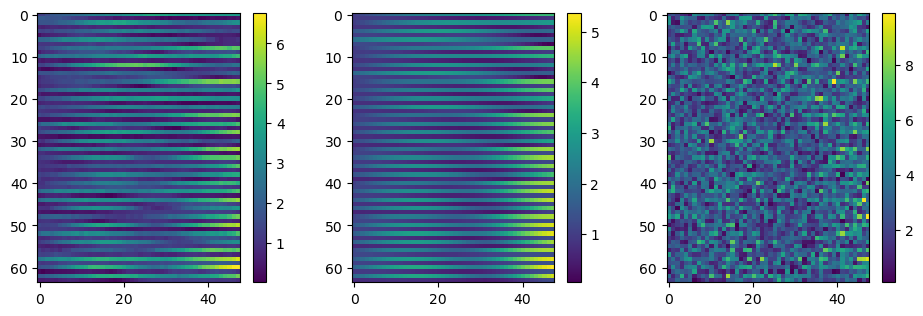

In [299]:
#idx = np.random.randint(0,235)
x = x_batch[idx,:].type(torch.complex64).detach()
y = u_batch[idx,:].type(torch.complex64).detach()

x_hat = lamp2(y)
plt.figure(figsize = (11.5,3.5))
plt.subplot(1,3,1)
plt.imshow(abs(x_hat).detach().numpy())
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(abs(x))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(abs(y))
plt.colorbar()

print(idx)


In [316]:
def train(optimizer, scheduler,criterion, model, clear_data, noisy_data, clear_test, noisy_test ,  epochs, device = 'cpu'):
    train_loss_history = []
    test_loss_history = []

    #model.to(device)
    previous_loss_value = 0
    degrade_counter = 0

    for epoch in range(epochs):
        model.train()
        current_mse = torch.tensor(0.0, dtype= torch.float64)
        test_mse = torch.tensor(0.0, dtype= torch.float64)
        
        optimizer.zero_grad()

        for cur_data_idx in range(clear_data.shape[0]):
            x = clear_data[cur_data_idx,:].type(torch.complex64).detach()
            y = noisy_data[cur_data_idx,:].type(torch.complex64).detach()

            x_hat = model(y)
            current_mse += criterion(x,x_hat)
        
        current_mse.backward(retain_graph=True)
        optimizer.step()
        train_loss_history.append(current_mse.detach().item())

        # -------------TESTING------------- 
        model.eval()
        with torch.no_grad():
            for cur_data_idx in range(clear_test.shape[0]):
                x = clear_test[cur_data_idx,:].type(torch.complex64).detach()
                y = noisy_test[cur_data_idx,:].type(torch.complex64).detach()

                test_mse += criterion(x,model(y))

        test_loss_history.append(test_mse.item())
        if epoch%5 == 0:
            print('Epoch: {0}. Train Loss : {1:9.5f}. Test Loss: {2:9.5f}'.format(epoch,current_mse.item(), test_mse.item()))

        if scheduler.optimizer.param_groups[0]['lr'] < 1e-7:
            break
        
        if test_mse.item() > previous_loss_value:
            degrade_counter += 1

            #if degrade_counter > 50:
            #    break
        
        elif degrade_counter > 0:
            degrade_counter -=1

        previous_loss_value = current_mse.item()
        
        scheduler.step(test_mse.detach().item())
    
    return train_loss_history, test_loss_history



In [283]:
lamp2.net[0].setTrainable(True)

In [284]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-5 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss :  34.98262. Test Loss:  64.75328
Epoch: 5. Train Loss :  35.20910. Test Loss:  47.38725
Epoch: 10. Train Loss :  32.26854. Test Loss:  47.08750
Epoch: 15. Train Loss :  30.41617. Test Loss:  45.83819
Epoch: 20. Train Loss :  29.12656. Test Loss:  46.15108
Epoch: 25. Train Loss :  28.13486. Test Loss:  44.73549
Epoch: 30. Train Loss :  27.40319. Test Loss:  45.38874
Epoch: 35. Train Loss :  26.75285. Test Loss:  44.70770
Epoch: 40. Train Loss :  26.24026. Test Loss:  44.89853
Epoch: 45. Train Loss :  25.82739. Test Loss:  44.85873
Epoch: 50. Train Loss :  25.78181. Test Loss:  45.03361


In [291]:
state = lamp2.state_dict()
state

OrderedDict([('B',
              tensor([[ 0.0672+0.0184j,  0.0928+0.0084j,  0.0981+0.0045j,  ...,
                        0.1295+0.0280j,  0.1089+0.0140j,  0.1269+0.0179j],
                      [ 0.0734+0.0145j,  0.0886+0.0041j,  0.0858+0.0020j,  ...,
                        0.1139-0.0164j,  0.0820-0.0193j,  0.1011-0.0298j],
                      [ 0.0803+0.0119j,  0.0782+0.0018j,  0.0709+0.0022j,  ...,
                        0.0684-0.0476j,  0.0310-0.0414j,  0.0455-0.0617j],
                      ...,
                      [ 0.0427+0.0040j,  0.0779+0.0113j,  0.0919+0.0196j,  ...,
                       -0.0138+0.0667j,  0.0104+0.0604j, -0.0059+0.0720j],
                      [ 0.0493+0.0168j,  0.0853+0.0170j,  0.1088+0.0164j,  ...,
                        0.0567+0.0900j,  0.0754+0.0750j,  0.0688+0.0936j],
                      [ 0.0589+0.0241j,  0.0917+0.0160j,  0.1089+0.0105j,  ...,
                        0.1124+0.0705j,  0.1082+0.0511j,  0.1182+0.0662j]])),
             ('net.0.

In [295]:
lamp2.net[2].alpha.data = lamp2.net[1].alpha.data.detach()
lamp2.net[2].beta.data = lamp2.net[1].beta.data.detach()

lamp2.net[0].setTrainable(False)
lamp2.net[1].setTrainable(False)
lamp2.net[2].setTrainable(True)

In [308]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-5 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss :  26.98482. Test Loss: 291.46324
Epoch: 5. Train Loss :  90.74867. Test Loss: 155.68344
Epoch: 10. Train Loss :  48.55491. Test Loss:  57.02792
Epoch: 15. Train Loss :  58.74883. Test Loss:  85.68846
Epoch: 20. Train Loss :  34.35631. Test Loss:  67.47972
Epoch: 25. Train Loss :  40.06988. Test Loss:  66.99382
Epoch: 30. Train Loss :  34.23891. Test Loss:  57.85837
Epoch: 35. Train Loss :  28.65346. Test Loss:  50.99753
Epoch: 40. Train Loss :  26.97838. Test Loss:  50.55561
Epoch: 45. Train Loss :  27.88618. Test Loss:  52.60922
Epoch: 50. Train Loss :  27.90531. Test Loss:  52.46586


In [303]:

lamp2.net[0].setTrainable(True)
lamp2.net[1].setTrainable(True)
lamp2.net[2].setTrainable(True)

In [317]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-8 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss :  24.58236. Test Loss:  48.73641
Epoch: 5. Train Loss :  24.54014. Test Loss:  48.79078
Epoch: 10. Train Loss :  24.51542. Test Loss:  48.72951
Epoch: 15. Train Loss :  24.46009. Test Loss:  48.77731
Epoch: 20. Train Loss :  24.47194. Test Loss:  48.75897
Epoch: 25. Train Loss :  24.47436. Test Loss:  48.75912
Epoch: 30. Train Loss :  24.47097. Test Loss:  48.76234
Epoch: 35. Train Loss :  24.47018. Test Loss:  48.76528
Epoch: 40. Train Loss :  24.46596. Test Loss:  48.76505
Epoch: 45. Train Loss :  24.46580. Test Loss:  48.76447
Epoch: 50. Train Loss :  24.46552. Test Loss:  48.76433
Epoch: 55. Train Loss :  24.46523. Test Loss:  48.76424
Epoch: 60. Train Loss :  24.46488. Test Loss:  48.76393


In [25]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_error(method= trainer.model,is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range)


/home/alex/GitHub/ML_for_channel_estimation/ch_est_net/utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u[:,:,0] + 1j*u[:,:,1], dtype = torch.complex64)


In [27]:
torch.save(detector_error_beam_net_1, 'results/lamp.pt')

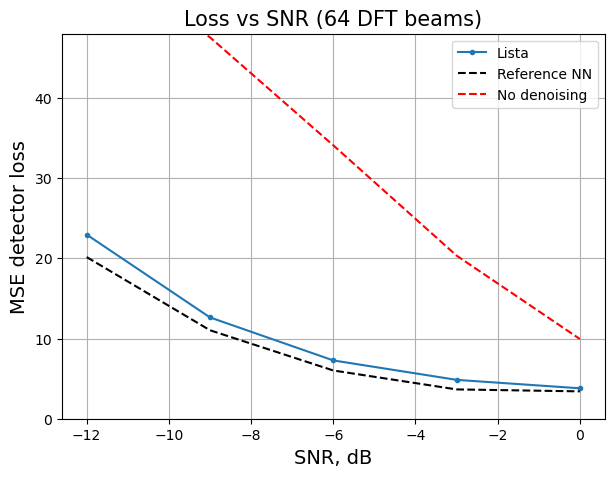

In [26]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
SNR_range = range(-12,1,3)
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Lista')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.ylim([0 , 48])
plt.grid()


plt.show()

In [18]:
from torchviz import make_dot, make_dot_from_trace

In [36]:
# x = torch.rand(64,48) + 1j*torch.rand(64,48)
# dot = make_dot(l(x), params=dict(l.named_parameters()), show_attrs=True, show_saved=True)
# dot.format = 'png'
# dot.render('model_image')

'model_image.png'

In [11]:
lista_beam =torch.tensor([21.1612, 10.924, 6.216, 3.526, 3.194])

torch.save(lista_beam, 'results/lista_Beam_net.pt')

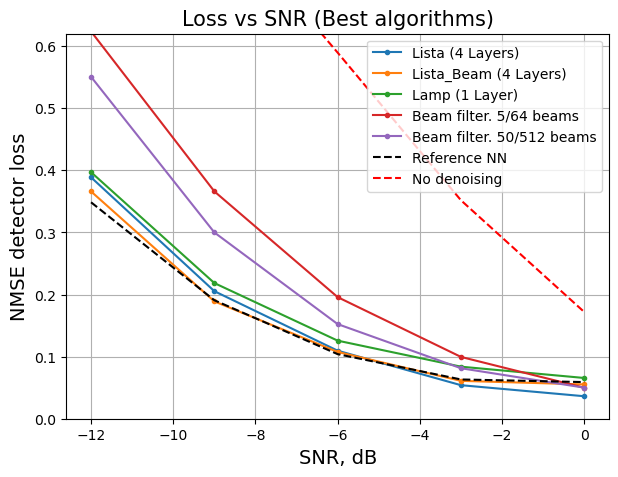

In [66]:
import matplotlib.pyplot as plt
plt.style.use("default")

norma = 57.8161

plt.figure(figsize=(7,5))
plt.plot(SNR_range, np.array(torch.load('results/lista_beam_net.pt'))/norma,'.-' ,label = 'Lista (4 Layers)')
plt.plot(SNR_range,np.array(torch.load('results/lista_Beam_net.pt'))/norma,'.-' ,label = 'Lista_Beam (4 Layers)')
plt.plot(SNR_range,np.array(torch.load('results/lamp.pt'))/norma,'.-' ,label = 'Lamp (1 Layer)')
plt.plot(SNR_range,np.array(torch.load('results/beams_5_of_64.pt'))/norma,'.-' ,label = 'Beam filter. 5/64 beams')
plt.plot(SNR_range,np.array(torch.load('results/beams_50_of_512.pt'))/norma,'.-' ,label = 'Beam filter. 50/512 beams')

plt.plot(SNR_range,np.array(reference)/norma,'--k',label = 'Reference NN' )
plt.plot(SNR_range,np.array(noise)/norma,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (Best algorithms)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("NMSE detector loss", fontsize = 14);
plt.ylim([0 , 0.62])
plt.grid()


plt.show()